# Schroedinger Ligand-based ADMET model

В данном блокноте проводится оценка качества модели, полученной с помощью встроенного тула AutoQSAR в Schroedinger

In [15]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
#import mols2grid
# mols2grid.useSVG=True
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import pandas as pd
from rdkit.Chem import AllChem, Draw, DataStructs
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error, balanced_accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from csv import reader

In [11]:
df = pd.read_csv('report_autoqsar_8k.csv', engine='python')
df

,ID Set Y(Obs) Cat(Obs) Cat(Pred) Prob Correct Name
0,1 test 1 2 2 0.9266 ...
1,2 test 1 2 1 1.0000 ...
2,3 train 1 2 2 0.9739 ...
3,4 test 1 2 2 1.0000 ...
4,5 train 1 2 1 0.9374 ...
...,...
4995,4996 train 0 1 1 1.0000 ...
4996,4997 train 0 1 1 1.0000 ...
4997,4998 train 0 1 1 1.0000 ...
4998,4999 train 1 2 2 1.0000 ...


In [16]:
def read_csv_with_nan(csv_file):
    # open file in read mode
    with open(csv_file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        a = []
        for row in csv_reader:
            a.append(row)
            # row variable is a list that represents a row in csv
            # print(row)
    d_schroedinger = pd.DataFrame(a)
    d_schroedinger.columns = d_schroedinger.iloc[0]
    d_schroedinger = d_schroedinger[1:]
    d_schroedinger.reset_index(drop=True, inplace=True)
    d_schroedinger = d_schroedinger.loc[:, d_schroedinger.columns.notnull()]
    return d_schroedinger

In [19]:
df[['ID', 'Set',  'Y(Obs)', 'Cat(Obs)', 'Cat(Pred)', 'Prob', 'Correct', 'Name']] = df["ID Set Y(Obs) Cat(Obs) Cat(Pred) Prob Correct Name"].str.split(" ", 1, expand=True)
# df["name_of_code"] = df["name_of_code"].str.strip("-")
print(df)

KeyError: 'ID Set Y(Obs) Cat(Obs) Cat(Pred) Prob Correct Name'

In [17]:
df = read_csv_with_nan("report_autoqsar_8k.csv")

In [20]:
df.iloc[0]

0
  ID Set   Y(Obs) Cat(Obs) Cat(Pred)  Prob  Correct  Name       1 test  1         2        2      0.9266   ...
Name: 0, dtype: object

In [4]:
df = pd.read_csv('qsar_test_17_8.csv',  engine='python')
df

,Stars,Title,Entry ID,Entry Name,Date Added,Date Modified,IC50_nM,class,Source Path,Source File,...,Chiralities Consistent,Variant,chiral flag,version,Pred Pred Class,Pred Pred Prob,Pred Pred Purity,Pred Domain Score,Pred Domain Alert,Job Name
0,NaN,Astemizole,35,ligprep_17-out.1,2021-08-23 18:28:54,2021-08-23 18:28:54,2,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,Astemizole-1,True,0,>=0.50,1.000,1.0,-0.016,0.0,qsar_test_17_8k
1,NaN,E-4031,36,ligprep_17-out.2,2021-08-23 18:28:54,2021-08-23 18:28:54,35,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,E-4031-1,True,0,>=0.50,0.989,1.0,-1.044,0.0,qsar_test_17_8k
2,NaN,Dofetilide,37,ligprep_17-out.3,2021-08-23 18:28:54,2021-08-23 18:28:54,11,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,Dofetilide-1,True,0,>=0.50,1.000,1.0,-1.519,0.0,qsar_test_17_8k
3,NaN,Pimozide,38,ligprep_17-out.4,2021-08-23 18:28:54,2021-08-23 18:28:54,3,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,Pimozide-1,True,0,>=0.50,0.981,1.0,-0.670,0.0,qsar_test_17_8k
4,NaN,26,39,ligprep_17-out.5,2021-08-23 18:28:54,2021-08-23 18:28:54,3240,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,26-1,True,0,<0.50,0.743,1.0,0.665,0.0,qsar_test_17_8k
5,NaN,48,40,ligprep_17-out.6,2021-08-23 18:28:54,2021-08-23 18:28:54,30000,0,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,48-1,True,0,<0.50,0.907,0.7,-0.307,0.0,qsar_test_17_8k
6,NaN,336,41,ligprep_17-out.7,2021-08-23 18:28:54,2021-08-23 18:28:54,2116,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,336-1,True,0,<0.50,0.693,1.0,0.678,0.0,qsar_test_17_8k
7,NaN,341,42,ligprep_17-out.8,2021-08-23 18:28:54,2021-08-23 18:28:54,30000,0,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,341-1,True,0,<0.50,0.845,1.0,0.100,0.0,qsar_test_17_8k
8,NaN,410,43,ligprep_17-out.9,2021-08-23 18:28:54,2021-08-23 18:28:54,7577,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,410-1,True,0,<0.50,0.702,1.0,0.757,0.0,qsar_test_17_8k
9,NaN,415,44,ligprep_17-out.10,2021-08-23 18:28:54,2021-08-23 18:28:54,7111,1,/Users/elly/ligprep_17,ligprep_17-out.sdf,...,True,415-1,True,0,<0.50,0.837,0.8,1.045,0.0,qsar_test_17_8k


In [7]:
df1 = df[['Title', "IC50_nM", 'class', 'Pred Pred Class', 'Pred Pred Prob']]

In [10]:
classs =[]
for i in df1['Pred Pred Class']:
    if i == '>=0.50':           
        classs.append(1)
    elif i == "<0.50":
        classs.append(0)
df1['preds'] = classs
df1

<ipython-input-10-52b9b374ee07>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['preds'] = classs


,Title,IC50_nM,class,Pred Pred Class,Pred Pred Prob,preds
0,Astemizole,2,1,>=0.50,1.000,1
1,E-4031,35,1,>=0.50,0.989,1
2,Dofetilide,11,1,>=0.50,1.000,1
3,Pimozide,3,1,>=0.50,0.981,1
4,26,3240,1,<0.50,0.743,0
5,48,30000,0,<0.50,0.907,0
6,336,2116,1,<0.50,0.693,0
7,341,30000,0,<0.50,0.845,0
8,410,7577,1,<0.50,0.702,0
9,415,7111,1,<0.50,0.837,0


In [8]:
df1

,Title,IC50_nM,class,Pred Pred Class,Pred Pred Prob
0,Astemizole,2,1,>=0.50,1.000
1,E-4031,35,1,>=0.50,0.989
2,Dofetilide,11,1,>=0.50,1.000
3,Pimozide,3,1,>=0.50,0.981
4,26,3240,1,<0.50,0.743
5,48,30000,0,<0.50,0.907
6,336,2116,1,<0.50,0.693
7,341,30000,0,<0.50,0.845
8,410,7577,1,<0.50,0.702
9,415,7111,1,<0.50,0.837


In [7]:
classs =[]
for i in df['Cat(Obs)']:
    if i == 1:           
        classs.append(0)
    elif i == 2:
        classs.append(1)
df['Real'] = classs
df

,ID,Set,Y(Obs),Cat(Obs),Cat(Pred),Prob,Correct,Real
0,1,test,0,1,1,0.7582,yes,0
1,2,train,1,2,2,0.7052,yes,1
2,3,train,1,2,2,1.0000,yes,1
3,4,train,1,2,2,1.0000,yes,1
4,5,train,0,1,1,1.0000,yes,0
...,...,...,...,...,...,...,...,...
4995,96,test,1,2,1,0.7770,no,1
4996,97,train,0,1,2,0.5681,no,0
4997,98,test,0,1,1,1.0000,yes,0
4998,99,test,1,2,1,0.8703,no,1


In [8]:
classs =[]
for i in df['Cat(Pred)']:
    if i == 1:           
        classs.append(0)
    elif i == 2:
        classs.append(1)
df['Pred'] = classs
df

,ID,Set,Y(Obs),Cat(Obs),Cat(Pred),Prob,Correct,Real,Pred
0,1,test,0,1,1,0.7582,yes,0,0
1,2,train,1,2,2,0.7052,yes,1,1
2,3,train,1,2,2,1.0000,yes,1,1
3,4,train,1,2,2,1.0000,yes,1,1
4,5,train,0,1,1,1.0000,yes,0,0
...,...,...,...,...,...,...,...,...,...
4995,96,test,1,2,1,0.7770,no,1,0
4996,97,train,0,1,2,0.5681,no,0,1
4997,98,test,0,1,1,1.0000,yes,0,0
4998,99,test,1,2,1,0.8703,no,1,0


In [9]:
del df["Cat(Obs)"]
del df["Cat(Pred)"]
df

,ID,Set,Y(Obs),Prob,Correct,Real,Pred
0,1,test,0,0.7582,yes,0,0
1,2,train,1,0.7052,yes,1,1
2,3,train,1,1.0000,yes,1,1
3,4,train,1,1.0000,yes,1,1
4,5,train,0,1.0000,yes,0,0
...,...,...,...,...,...,...,...
4995,96,test,1,0.7770,no,1,0
4996,97,train,0,0.5681,no,0,1
4997,98,test,0,1.0000,yes,0,0
4998,99,test,1,0.8703,no,1,0


In [10]:
df_train = df[df['Set'] == "train"]
df_train

,ID,Set,Y(Obs),Prob,Correct,Real,Pred
1,2,train,1,0.7052,yes,1,1
2,3,train,1,1.0000,yes,1,1
3,4,train,1,1.0000,yes,1,1
4,5,train,0,1.0000,yes,0,0
5,6,train,0,1.0000,yes,0,0
...,...,...,...,...,...,...,...
4991,92,train,1,0.8777,yes,1,1
4993,94,train,0,1.0000,yes,0,0
4994,95,train,0,1.0000,yes,0,0
4996,97,train,0,0.5681,no,0,1


In [11]:
df_test = df[df['Set'] == "test"]
df_test

,ID,Set,Y(Obs),Prob,Correct,Real,Pred
0,1,test,0,0.7582,yes,0,0
10,11,test,0,1.0000,yes,0,0
16,17,test,1,0.8070,no,1,0
18,19,test,0,1.0000,yes,0,0
29,30,test,1,1.0000,no,1,0
...,...,...,...,...,...,...,...
4984,85,test,1,0.5111,no,1,0
4992,93,test,0,1.0000,no,0,1
4995,96,test,1,0.7770,no,1,0
4997,98,test,0,1.0000,yes,0,0


In [12]:
from sklearn.metrics import confusion_matrix
# Расчет TN, TP, FN, FP:
tn, fp, fn, tp = confusion_matrix(df_test["Real"], df_test["Pred"]).ravel()
print(tn, fp, fn, tp)

495 143 172 439


In [13]:
from sklearn.metrics import classification_report
target_names = ["class nonblockers", "class blockers"]
print(classification_report(df_train["Real"], df_train["Pred"], target_names=target_names))

                   precision    recall  f1-score   support

class nonblockers       0.83      0.83      0.83      1917
   class blockers       0.82      0.83      0.83      1834

         accuracy                           0.83      3751
        macro avg       0.83      0.83      0.83      3751
     weighted avg       0.83      0.83      0.83      3751



In [14]:
from sklearn.metrics import classification_report
target_names = ["class nonblockers", "class blockers"]
print(classification_report(df_test["Real"], df_test["Pred"], target_names=target_names))

                   precision    recall  f1-score   support

class nonblockers       0.74      0.78      0.76       638
   class blockers       0.75      0.72      0.74       611

         accuracy                           0.75      1249
        macro avg       0.75      0.75      0.75      1249
     weighted avg       0.75      0.75      0.75      1249



In [17]:


# probs = classif.predict_proba(X_test)
# preds = probs[:,1]]
y_test = df_train["Real"]
prob = df_train["Prob"]

fpr, tpr, threshold = metrics.roc_curve(y_test, prob, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)

In [19]:
df_train["Real"]

1       1
2       1
3       1
4       0
5       0
       ..
4991    1
4993    0
4994    0
4996    0
4999    0
Name: Real, Length: 3751, dtype: int64

In [20]:
df_train["Prob"]

1       0.7052
2       1.0000
3       1.0000
4       1.0000
5       1.0000
         ...  
4991    0.8777
4993    1.0000
4994    1.0000
4996    0.5681
4999    1.0000
Name: Prob, Length: 3751, dtype: float64

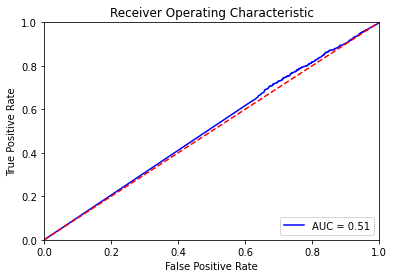

In [18]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error, balanced_accuracy_score, roc_auc_score, roc_curve, confusion_matrix

# probs = classif.predict_proba(X_test)
# preds = probs[:,1]]
y_test = df1["class"]
prob = df1["Pred Pred Prob"]
fpr, tpr, threshold = metrics.roc_curve(y_test, prob, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)

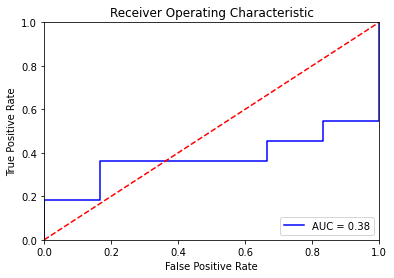

In [12]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
# C AutoQsar тоже все очень плохо